In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import matplotlib.animation as animation

In [109]:


def f(x):
    return np.cos(x[0] * (2 * np.pi)) +  0.3 * np.sin(3 * x[0] * (2 * np.pi)) -  0.2 * np.cos(4 * x[0] * (2 * np.pi)) + \
            np.sin(x[1] * (2 * np.pi)) +  0.1 * np.cos(3 * x[1] * (2 * np.pi)) -  0.5 * np.cos(4 * x[1] * (2 * np.pi)) + \
            np.cos(2 * (x[0] + x[1]) * (2 * np.pi))

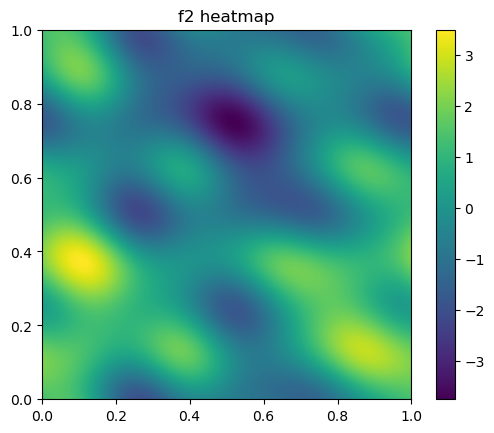

In [111]:
x1, x2 = np.meshgrid(np.arange(0,1, 0.001), np.arange(0,1, 0.001))
y = f(np.stack((x1,x2)))
plt.imshow(y,extent=[0,1,0,1], origin='lower')
plt.title("f2 heatmap")
plt.colorbar()

In [64]:
sigma = 1
l = 1

p1 = np.array([[1, 2, 3],
              [4, 5, 6]])
p2 = np.array([[1, 2, 3]])

kernel = lambda x1, x2 : (sigma ** 2) * np.exp(- (cdist(x1,x2) ** 2) / (2*l**2))

print('p1, p2 (should be (2,1))', kernel(p1,p2).shape, kernel(p1,p2))
print('p1, p1 (should be (2,2))', kernel(p1,p1).shape, kernel(p1,p1))
print('p2, p2 (should be (1,1))', kernel(p2,p2).shape, kernel(p2,p2))

p1, p2 (should be (2,1)) (2, 1) [[1.00000000e+00]
 [1.37095909e-06]]
p1, p1 (should be (2,2)) (2, 2) [[1.00000000e+00 1.37095909e-06]
 [1.37095909e-06 1.00000000e+00]]
p2, p2 (should be (1,1)) (1, 1) [[1.]]


In [269]:
class BayesianOptimizer:

    def __init__(self, dim=2):
        self.points = np.array([[]])
        self.values = np.array([])
        self.n_points = 0

        self.sigma = 1
        
        self.kernel = lambda x1, x2 : (sigma ** 2) * np.exp(- (cdist(x1,x2) ** 2) / (2*l**2))
        self.dim = dim

    def add_point(self, new_point, new_value):

        # todo : rename to add_points and add asserts on the shape of new_point
        if self.n_points > 0:
            self.points = np.append(self.points, new_point[np.newaxis, :], axis=0)
            self.values = np.append(self.values, new_value)

        else:
            self.points = new_point[np.newaxis, :]
            self.values = np.array([new_value])
        
        self.n_points += 1
        
        if self.n_points > 1:
            self.K = kernel(self.points, self.points)
            self.K_inv = np.linalg.inv(self.K)
        
    def surrogate(self, x):

        if np.ndim(x) == 1:
            K_star = self.kernel(self.points, x[np.newaxis, :])
            mu_star = K_star.T @ self.K_inv @ self.values[:,np.newaxis,]
            cov_star = self.kernel(x[np.newaxis, :], x[np.newaxis, :]) - K_star.T @ self.K_inv @ K_star

            return mu_star, cov_star
            #lambda u: 1./(np.sqrt(2.*np.pi) * cov_star[0,0]) * np.exp( - (1/2) * ((u - mu_star) ** 2) / cov_star[0,0])

        else:
            # todo assert second dimension of x is self.dim 
            K_star = self.kernel(self.points, x)
            mu_star = K_star.T @ self.K_inv @ self.values[:,np.newaxis,]
            cov_star = self.kernel(x, x) - K_star.T @ self.K_inv @ K_star
            return mu_star, cov_star

    def next_point(self, proximity_weight=0):
        return ()




point1 = np.array([0.5,.8])
point2 = np.array([0.7, 0.3])

bayes_opt = BayesianOptimizer()
bayes_opt.add_point(point1, f(point1))
bayes_opt.add_point(point2, f(point2))

print('A', bayes_opt.surrogate(np.array([0.1, 0.2])))
print('B', bayes_opt.surrogate(np.array([[0.1, 0.2], [0.3, 0.9]])))

A (array([[0.43556299]]), array([[0.29847139]]))
B (array([[ 0.43556299],
       [-4.39935892]]), array([[0.29847139, 0.06253417],
       [0.06253417, 0.02782533]]))


## One dimension example

In [268]:
def f1(x):
    return np.cos(x * (2 * np.pi)) +  0.3 * np.sin(3 * x * (2 * np.pi)) -  0.2 * np.cos(4 * x * (2 * np.pi))

In [321]:
a = np.linspace(0,1, 15)
np.random.shuffle(a)
a

array([0.42857143, 0.85714286, 0.07142857, 0.14285714, 0.21428571,
       0.64285714, 0.71428571, 0.28571429, 0.        , 0.5       ,
       1.        , 0.35714286, 0.57142857, 0.92857143, 0.78571429])

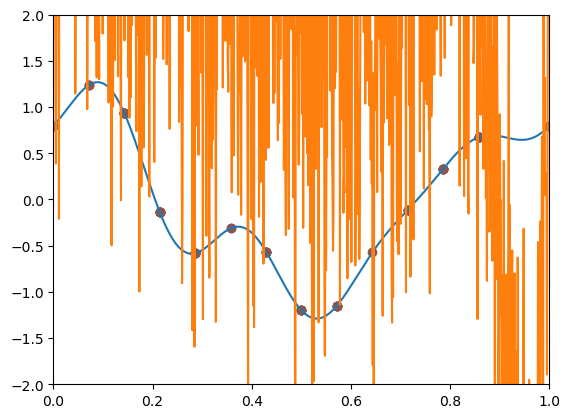

In [324]:
x = np.linspace(0,1, 1000)
y = f1(x)
bayes_opt = BayesianOptimizer()


fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([-2, 2])
ax.plot(x, y, label = "true function")

#points = np.random.rand(11,1)
points = np.linspace(0,1, 15)[:,np.newaxis]
np.random.shuffle(points)
scat = ax.scatter([], [], label='sample')
surrogate_function, = ax.plot([], [], label='surrogate')

def animate(i):
    #print(i, bayes_opt.points, bayes_opt.values, points[i], f1(points[i]))
    if bayes_opt.n_points <= i:
        bayes_opt.add_point(points[i], f1(points[i])[0])

    scat= ax.scatter(bayes_opt.points[:,0], bayes_opt.values) #.set_offsets((bayes_opt.points[:,0], bayes_opt.values))
    surrogate_function.set_data([], [])

    if bayes_opt.n_points >= 2 :
        mu, cov = bayes_opt.surrogate(x[:,np.newaxis])
        surrogate_function.set_data(x, mu[:,0])
    return (scat, surrogate_function,)


ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(points) - 1, interval=50)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=0.5,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('bayesian_regression_random_draw.gif', writer=writer)

plt.show()


Text(0.5, 1.0, 'f plot')

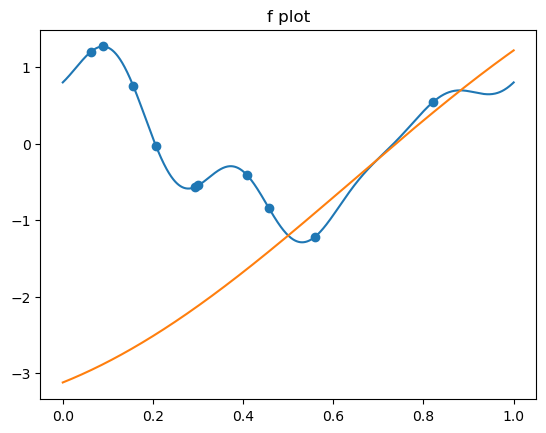

In [312]:
x = np.linspace(0,1, 1000)
y = f1(x)
plt.plot(x, y)
plt.plot(x, mu[:, 0])
plt.scatter(bayes_opt.points[:, 0], bayes_opt.values)
plt.title("f plot")

In [212]:
np.random.rand(5,1).shape

(5, 1)

Text(0.5, 1.0, 'f plot')

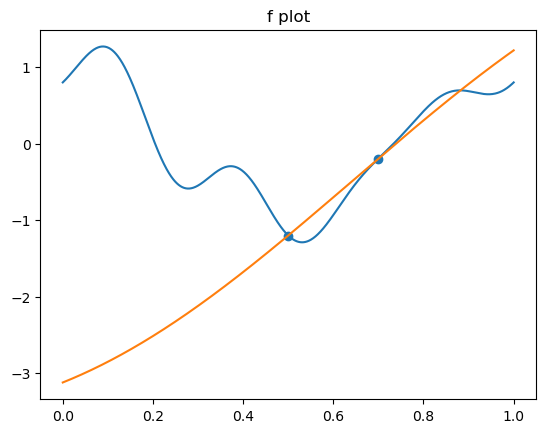

In [215]:
x = np.linspace(0,1, 1000)
y = f1(x)
plt.plot(x, y)
plt.plot(x, mu[:, 0])
plt.scatter(bayes_opt.points[:, 0], bayes_opt.values)
plt.title("f plot")

## One dimension example